In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21864 entries, 0 to 21863
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_id                          21864 non-null  object        
 1   order_id                         21864 non-null  object        
 2   purchase_ts                      21864 non-null  object        
 3   purchase_ts_cleaned              21863 non-null  datetime64[ns]
 4   purchase_year                    21864 non-null  Int64         
 5   purchase_month                   21864 non-null  Int64         
 6   time_to_ship                     21864 non-null  Int64         
 7   ship_ts                          21864 non-null  datetime64[ns]
 8   product_name                     21864 non-null  object        
 9   product_name_cleaned             21864 non-null  object        
 10  product_id                       21864 non-null  object   

In [3]:
import pandas as pd
from collections import deque

# Prepare data
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])
df = df.sort_values('purchase_ts_cleaned')

# Create complete daily grid
date_range = pd.date_range(
    start=df['purchase_ts_cleaned'].min().floor('D'),
    end=df['purchase_ts_cleaned'].max().floor('D'),
    freq='D'
)

daily_users = (
    df.groupby(df['purchase_ts_cleaned'].dt.floor('D'))['user_id']
    .agg(lambda x: set(x))
    .reindex(date_range, fill_value=set())
    .reset_index()
    .rename(columns={'index': 'date', 'user_id': 'user_set'})
)

# Rolling 30-day MAB (optimized)
rolling_window = deque(maxlen=30)
mab_values = []

for user_set in daily_users['user_set']:
    rolling_window.append(user_set)
    
    if len(rolling_window) < 30:
        mab_values.append(None)
    else:
        mab_values.append(len(set().union(*rolling_window)))

daily_users['monthly_active_buyers'] = mab_values

# Extract date components
daily_users['year'] = daily_users['date'].dt.year
daily_users['month_num'] = daily_users['date'].dt.month
daily_users['month_name'] = daily_users['date'].dt.strftime('%b')

# Get month-end MAB values
monthly_mab = (
    daily_users[daily_users['monthly_active_buyers'].notna()]
    .groupby(['year', 'month_num', 'month_name'], as_index=False)  # Keep month_num
    .last()
    [['year', 'month_num', 'month_name', 'monthly_active_buyers']]  # Include month_num
    .sort_values(['year', 'month_num'])  # Now it exists!
)

# Optional: Drop month_num if you don't need it in output
# monthly_mab = monthly_mab.drop(columns=['month_num'])

print(monthly_mab)

    year  month_num month_name  monthly_active_buyers
0   2019          1        Jan                  399.0
1   2019          2        Feb                  345.0
2   2019          3        Mar                  503.0
3   2019          4        Apr                  530.0
4   2019          5        May                  487.0
5   2019          6        Jun                  474.0
6   2019          7        Jul                  484.0
7   2019          8        Aug                  502.0
8   2019          9        Sep                  577.0
9   2019         10        Oct                  473.0
10  2019         11        Nov                  604.0
11  2019         12        Dec                  650.0
12  2020          1        Jan                  290.0
13  2020          2        Feb                  671.0
14  2020          3        Mar                  955.0
15  2020          4        Apr                 1183.0
16  2020          5        May                 1191.0
17  2020          6        J

In [4]:
import pandas as pd

# Assuming df is your cleaned orders dataframe
# Ensure purchase_ts_cleaned is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# 1️⃣ Create a cohort column — first purchase month per user
first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .rename('cohort')
)

df = df.join(first_purchase, on='user_id')

# 2️⃣ Count purchases per user
user_purchase_counts = df.groupby('user_id')['order_id'].nunique().rename('purchase_count')

# 3️⃣ Merge back with cohort info
user_data = df[['user_id', 'cohort']].drop_duplicates().merge(user_purchase_counts, on='user_id')

# 4️⃣ Calculate repeat purchase rate per cohort
rpr = (
    user_data.groupby('cohort')
    .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)
    .reset_index(name='repeat_purchase_rate_%')
)

# 5️⃣ Sort and clean for display
rpr['cohort'] = rpr['cohort'].astype(str)
rpr = rpr.sort_values('cohort').reset_index(drop=True)

print(rpr)


     cohort  repeat_purchase_rate_%
0   2019-01               14.797136
1   2019-02                5.345912
2   2019-03                4.280156
3   2019-04                4.406130
4   2019-05                3.434343
5   2019-06                3.640257
6   2019-07               13.078471
7   2019-08               11.284047
8   2019-09               19.366197
9   2019-10                5.010438
10  2019-11               14.020270
11  2019-12               19.908815
12  2020-01               12.631579
13  2020-02                3.291536
14  2020-03                2.564103
15  2020-04                3.889369
16  2020-05                2.350966
17  2020-06                3.187614
18  2020-07                7.714286
19  2020-08               10.488246
20  2020-09               16.025641
21  2020-10                3.093812
22  2020-11               10.157618
23  2020-12               19.304734
24  2021-01               31.241473
25  2021-02                0.240964


C:\Users\shaif\AppData\Local\Temp\ipykernel_15776\452118629.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)


In [5]:
# Save rpr DataFrame to Excel
rpr.to_excel("repeat_purchase_rate.xlsx", index=False)



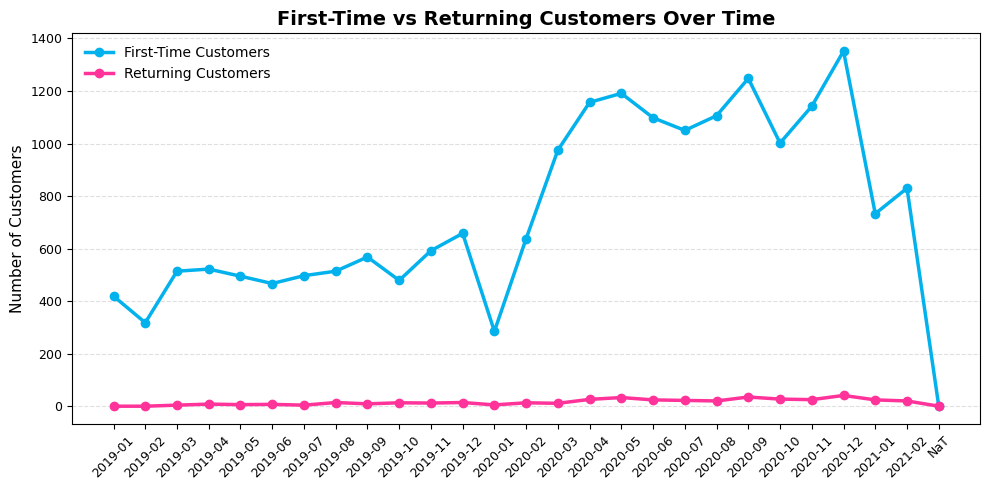

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure purchase date is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# Extract Year-Month for grouping
df['year_month'] = df['purchase_ts_cleaned'].dt.to_period('M').astype(str)

# Get each user's first purchase month
first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .astype(str)
    .rename('first_purchase_month')
)
df = df.join(first_purchase, on='user_id')

# Label customers per order as 'New' or 'Returning'
df['customer_type'] = df.apply(
    lambda x: 'New' if x['year_month'] == x['first_purchase_month'] else 'Returning',
    axis=1
)

# Count unique users by type per month
customer_counts = (
    df.groupby(['year_month', 'customer_type'])['user_id']
    .nunique()
    .reset_index(name='customer_count')
)

# Pivot for line chart
pivot = customer_counts.pivot(index='year_month', columns='customer_type', values='customer_count').fillna(0)

# --- 🎨 Visualization ---
plt.figure(figsize=(10,5))
plt.plot(pivot.index, pivot['New'], color="#03b2ed", linewidth=2.5, marker='o', label='First-Time Customers')
plt.plot(pivot.index, pivot['Returning'], color="#FF3399", linewidth=2.5, marker='o', label='Returning Customers')

# Style tweaks
plt.title("First-Time vs Returning Customers Over Time", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Number of Customers", fontsize=11)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


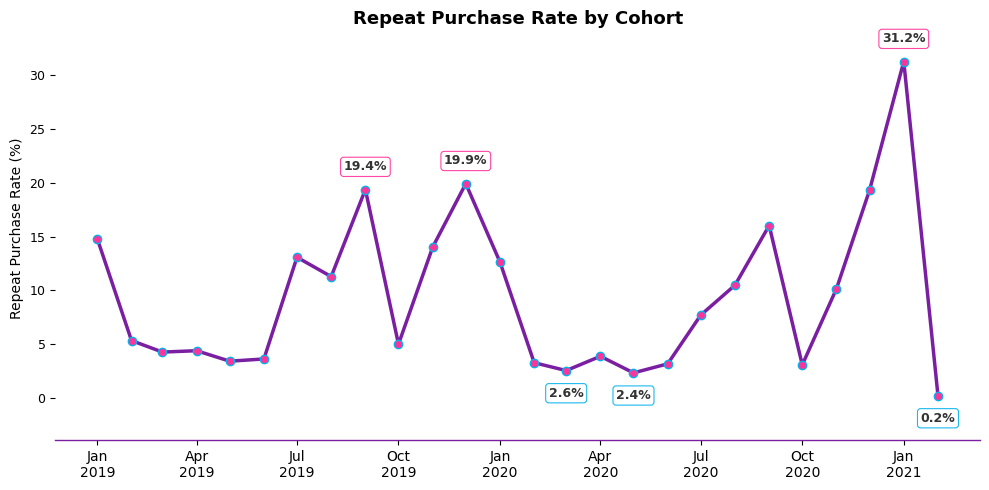

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime and sort
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify top 3 and bottom 3
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

# Continuous line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color="#7B1FA2",
    linewidth=2.5,
    marker='o',
    markerfacecolor="#FF3399",
    markeredgecolor="#03b2ed"
)

# --- Quarter-based ticks ---
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    [f"{m}\n{y}" for m, y in zip(
        quarter_ticks['cohort'].dt.strftime('%b'),
        quarter_ticks['cohort'].dt.strftime('%Y')
    )],
    fontsize=9
)

# --- Highlight labels ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#FF3399", lw=0.8, alpha=0.9)
    )

for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#03b2ed", lw=0.8, alpha=0.9)
    )

# --- Styling ---
ax.set_title("Repeat Purchase Rate by Cohort", fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.set_ylabel("Repeat Purchase Rate (%)", fontsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.grid(False)

# Hide outline
for spine in ax.spines.values():
    spine.set_visible(False)

# --- Lower the x-axis line (step below the chart) ---
ax.spines['bottom'].set_position(('outward', 20))  # moves x-axis 20px lower
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color("#7B1FA2")
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


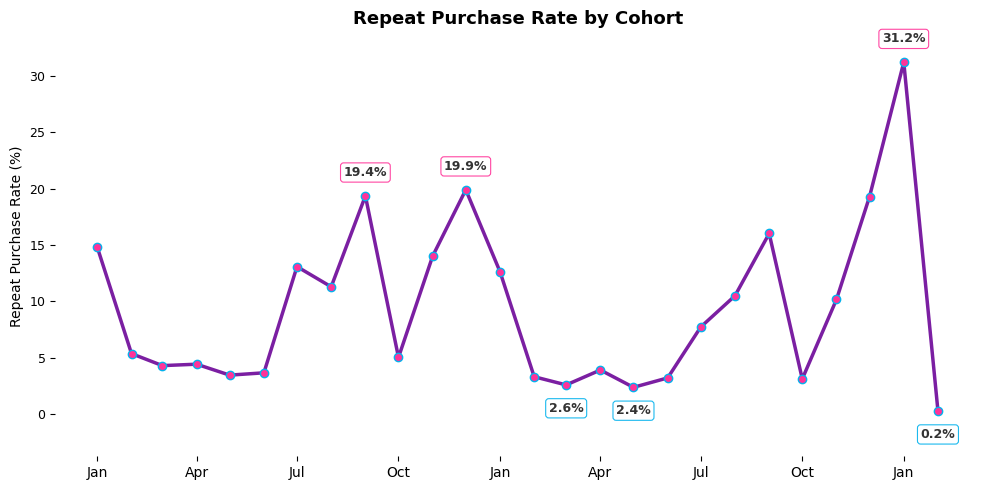

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime and sort
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify top 3 and bottom 3
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

# Continuous line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color="#7B1FA2",
    linewidth=2.5,
    marker='o',
    markerfacecolor="#FF3399",
    markeredgecolor="#03b2ed"
)

# --- Quarter-based ticks ---
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    [m for m in quarter_ticks['cohort'].dt.strftime('%b')],
    fontsize=9
)

# --- Highlight labels ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#FF3399", lw=0.8, alpha=0.9)
    )

for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#03b2ed", lw=0.8, alpha=0.9)
    )

# --- Styling ---
ax.set_title("Repeat Purchase Rate by Cohort", fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.set_ylabel("Repeat Purchase Rate (%)", fontsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.grid(False)

# Hide outline
for spine in ax.spines.values():
    spine.set_visible(False)

# --- Lower the x-axis line (step below the chart) ---
ax.spines['bottom'].set_position(('outward', 20))  # moves x-axis 20px lower
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


In [15]:
rpr

,cohort,repeat_purchase_rate_%
0,2019-01-01,14.797136
1,2019-02-01,5.345912
2,2019-03-01,4.280156
3,2019-04-01,4.406130
4,2019-05-01,3.434343
5,2019-06-01,3.640257
6,2019-07-01,13.078471
7,2019-08-01,11.284047
8,2019-09-01,19.366197
9,2019-10-01,5.010438


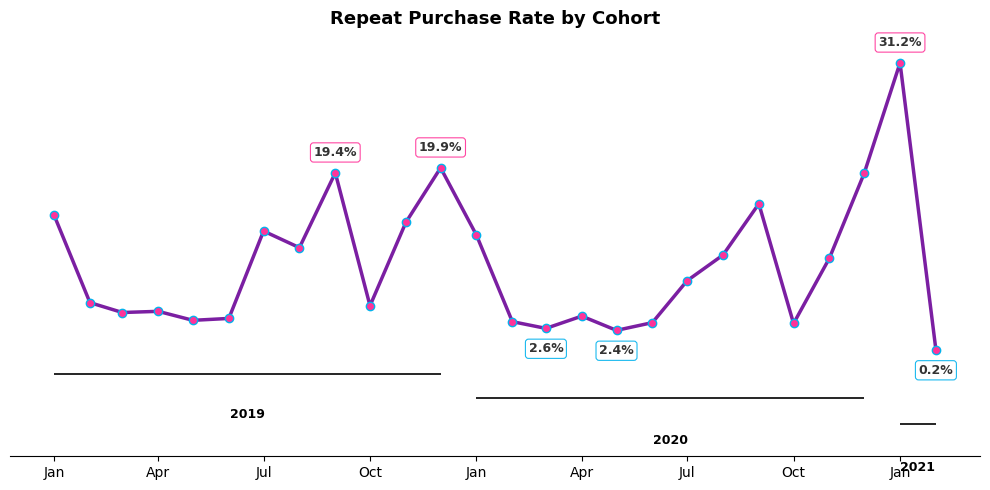

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime and sort
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify top 3 and bottom 3
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

# Continuous line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color="#7B1FA2",
    linewidth=2.5,
    marker='o',
    markerfacecolor="#FF3399",
    markeredgecolor="#03b2ed",
    zorder=3
)

# --- Quarter-based ticks ---
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    [m for m in quarter_ticks['cohort'].dt.strftime('%b')],
    fontsize=9
)

# --- Highlight labels ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#FF3399", lw=0.8, alpha=0.9)
    )

for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#03b2ed", lw=0.8, alpha=0.9)
    )

# --- Remove y-axis completely ---
ax.set_ylabel("")
ax.set_yticks([])
ax.tick_params(axis='y', length=0)  # hide y-axis ticks

# --- Styling ---
ax.set_title("Repeat Purchase Rate by Cohort", fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.grid(False)

# Hide all spines except bottom
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

# --- Draw year line beneath x-axis ---
years = rpr['cohort'].dt.year.unique()
for year in years:
    start = rpr[rpr['cohort'].dt.year == year]['cohort'].min()
    end = rpr[rpr['cohort'].dt.year == year]['cohort'].max()
    ax.hlines(y=ax.get_ylim()[0] - 1, xmin=start, xmax=end, color='black', linewidth=1.2)  # line for year
    ax.text(
        x=start + (end - start)/2,
        y=ax.get_ylim()[0] - 2,
        s=str(year),
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold'
    )

# Lower the x-axis a bit
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['bottom'].set_visible(True)

plt.tight_layout()
plt.show()
